In [ ]:
# based on https://www.tensorflow.org/tutorials/images/transfer_learning

In [1]:
from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_hub as hub

import os
import sys

tf.__version__

2023-04-14 14:57:49.662173: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.12.0'

In [6]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [12]:
batch_size = 64
IMG_SIZE = 224
data_dir = "/tf/dataset/cavity_images"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=batch_size,
)
class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

Found 20067 files belonging to 10 classes.
Using 16054 files for training.
Found 20067 files belonging to 10 classes.
Using 4013 files for validation.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [26]:
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

In [28]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE)
IMG_SHAPE = IMG_SHAPE + (3,)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')

In [29]:
#image_batch, label_batch = next(iter(train_ds))
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

In [30]:
base_model.trainable = False

In [34]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [35]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 10)


In [36]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  0          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                  

 ivation)                                                                                         
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 48)   9216        ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_a

 block4b_add (Add)              (None, 14, 14, 96)   0           ['block4b_drop[0][0]',           
                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 14, 14, 384)  36864       ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 14, 14, 384)  1536       ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
          

                                                                                                  
 block5b_dwconv2 (DepthwiseConv  (None, 14, 14, 672)  6048       ['block5b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 672)  0          ['block5b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5b_s

 )                                                                                                
                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 672)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 672)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5d_se_squeeze[0][0]']     
                                                                                                  
 block5d_s

 block6a_se_squeeze (GlobalAver  (None, 672)         0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, 7, 7, 672)    0           ['block6a_activation[0][0]',     
          

                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 192)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 7, 7, 192)    0           ['block6c_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 192)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 192)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6e_add[0][0]']            
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6f_expand_conv[0][0]']    
 ization) 

                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6h_d

In [37]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [40]:
hist = model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5


2023-04-14 15:19:00.669995: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x21729870 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-14 15:19:00.670108: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-04-14 15:19:00.703418: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/251 [..............................] - ETA: 24:29 - loss: 2.4657 - accuracy: 0.1094

2023-04-14 15:19:00.988552: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9833

2023-04-14 15:19:29.250336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4013]
	 [[{{node Placeholder/_4}}]]
2023-04-14 15:19:29.250659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4013]
	 [[{{node Placeholder/_0}}]]


251/251 [==============================] - 42s 146ms/step - loss: 0.0661 - accuracy: 0.9833 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 2/5
251/251 [==============================] - 34s 134ms/step - loss: 0.0051 - accuracy: 0.9994 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 3/5
251/251 [==============================] - 34s 135ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 4/5
251/251 [==============================] - 34s 134ms/step - loss: 0.0015 - accuracy: 0.9998 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/5
251/251 [==============================] - 34s 134ms/step - loss: 8.4798e-04 - accuracy: 1.0000 - val_loss: 9.1675e-04 - val_accuracy: 1.0000


In [41]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

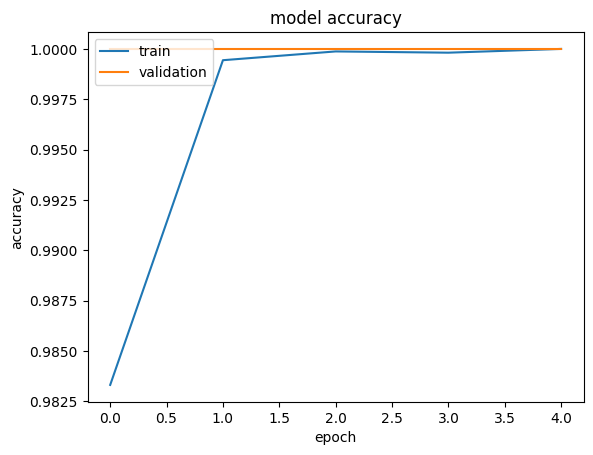

In [42]:
plot_hist(hist)